In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cgan-model/cgan_model_shoes_v3.pth
/kaggle/input/edges2shoes-dataset/metadata.csv
/kaggle/input/edges2shoes-dataset/val/101_AB.jpg
/kaggle/input/edges2shoes-dataset/val/4_AB.jpg
/kaggle/input/edges2shoes-dataset/val/26_AB.jpg
/kaggle/input/edges2shoes-dataset/val/162_AB.jpg
/kaggle/input/edges2shoes-dataset/val/119_AB.jpg
/kaggle/input/edges2shoes-dataset/val/72_AB.jpg
/kaggle/input/edges2shoes-dataset/val/34_AB.jpg
/kaggle/input/edges2shoes-dataset/val/163_AB.jpg
/kaggle/input/edges2shoes-dataset/val/47_AB.jpg
/kaggle/input/edges2shoes-dataset/val/68_AB.jpg
/kaggle/input/edges2shoes-dataset/val/138_AB.jpg
/kaggle/input/edges2shoes-dataset/val/177_AB.jpg
/kaggle/input/edges2shoes-dataset/val/183_AB.jpg
/kaggle/input/edges2shoes-dataset/val/161_AB.jpg
/kaggle/input/edges2shoes-dataset/val/135_AB.jpg
/kaggle/input/edges2shoes-dataset/val/194_AB.jpg
/kaggle/input/edges2shoes-dataset/val/9_AB.jpg
/kaggle/input/edges2shoes-dataset/val/168_AB.jpg
/kaggle/input/edges2shoes-datas

In [38]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/edges2shoes-dataset/train"
VAL_DIR = "/kaggle/input/edges2shoes-dataset/val"
LEARNING_RATE = 2e-4
BETA1 = 0.5
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 64
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 800
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "/kaggle/working/disc.pth.tar"
CHECKPOINT_GEN = "/kaggle/working/gen.pth.tar"

In [39]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_size, channels):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)  # Embedding for num_classes labels

        # First linear layer: latent_dim + label embedding
        self.l1 = nn.Linear(latent_dim + num_classes, 1024 * 4 * 4)  # Produces 1024 x 4 x 4 feature map


        
        self.conv_blocks = nn.Sequential(
            # First transposed convolutional layer: 1024x4x4 -> 512x8x8
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # Output: 512x8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Second transposed convolutional layer: 512x8x8 -> 256x16x16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: 256x16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Third transposed convolutional layer: 256x16x16 -> 128x32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 128x32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth transposed convolutional layer: 128x32x32 -> 3x64x64 (RGB image)
            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1),  # Output: 3x64x64
            nn.Tanh()  # Tanh activation for final output
        )

    def forward(self, z, labels):
        # Embed the labels and concatenate them with the latent vector
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)

        # Pass the concatenated input through the first linear layer
        out = self.l1(gen_input)
        out = out.view(out.size(0), 1024, 4, 4)  # Reshape to 1024x4x4

        # Pass the result through the transposed convolutional layers
        img = self.conv_blocks(out)
        return img  # Output is (batch_size, channels, img_size, img_size)

latent_dim = 100  # Size of the latent space (z)
num_classes = 4  # You can change this to any number of classes
img_size = 64  # Size of the image (64x64)
channels = 3  # Number of image channels (e.g., 3 for RGB, 1 for grayscale)
generator = Generator(latent_dim, num_classes, img_size, channels).cuda()
print(generator)


Generator(
  (label_emb): Embedding(4, 4)
  (l1): Linear(in_features=104, out_features=16384, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

/tmp/ipykernel_36/3302282076.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("/kaggle/input/cgan-model/cgan_model_shoes_v3.pth")


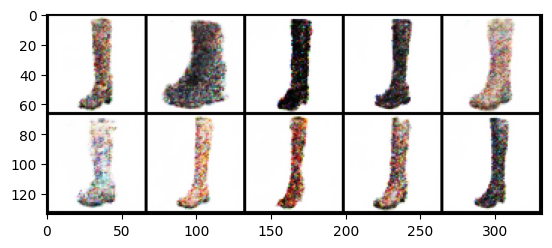

In [40]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
loaded_model = torch.load("/kaggle/input/cgan-model/cgan_model_shoes_v3.pth")
generator.load_state_dict(loaded_model['generator_state_dict'])
generator.eval()
num_samples = 10
z = torch.randn(num_samples, 100).to(DEVICE)
labels = torch.randint(0,1, (num_samples,)).mul(2).to(DEVICE)
#labels = torch.tensor([0]).to(DEVICE)  # Example: alternating labels
with torch.no_grad():
    sample_images = generator(z, labels).data.cpu()
    

# Visualize the generated images
grid = make_grid(sample_images, nrow=5, normalize=True).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.show()

<class 'numpy.ndarray'>


(Text(0.5, 1.0, 'Edge Image'), ([], []), ([], []))

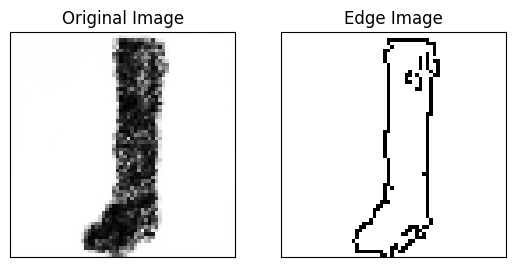

In [41]:
import cv2
test_shoe = sample_images[2].permute(1,2,0).numpy()
if test_shoe.dtype != np.uint8:
    test_shoe = (test_shoe * 255).astype(np.uint8)
    test_shoe = cv2.cvtColor(test_shoe, cv2.COLOR_RGB2GRAY)
print(type(test_shoe))
edges = cv2.Canny(test_shoe, 400, 600)
edges = cv2.bitwise_not(edges)
plt.subplot(121),plt.imshow(test_shoe,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

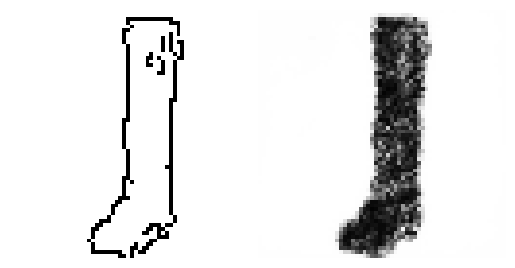

In [42]:

horizontal_concat = cv2.hconcat([edges, test_shoe])
horizontal_concat_rgb = cv2.cvtColor(horizontal_concat, cv2.COLOR_BGR2RGB)
plt.imshow(horizontal_concat_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [43]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

/tmp/ipykernel_36/4114863037.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("/kaggle/input/cgan-model/cgan_model_shoes_v3.pth")


50825
X Shape :- torch.Size([5, 3, 64, 64])
Y Shape :- torch.Size([5, 3, 64, 64])


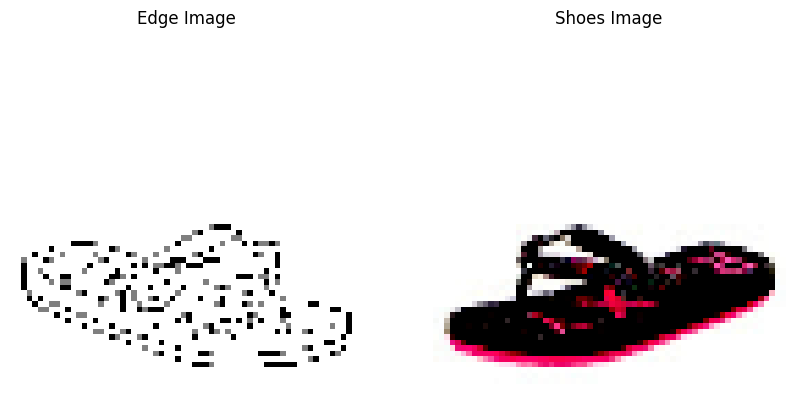

In [59]:
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

############## Augmentations ###############

both_transform = A.Compose(
    [A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE)], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

class Edge2Shoe_Data(Dataset):
    def __init__(self, root, num_generated_samples=100):
        self.root = root
        list_files = os.listdir(self.root)
        #### Removing '.ipynb_checkpoints' from the list
        self.n_samples = [f for f in list_files if not f.startswith('.')]
        self.num_generated_samples = num_generated_samples
        self.generated_samples = self.__genshoes(self.num_generated_samples)  # Generate augmented data

    def __len__(self):
        # Total length includes the real dataset plus the generated samples
        return len(self.n_samples) + len(self.generated_samples)

    def __genshoes(self, samples):
        # Load pre-trained generator
        loaded_model = torch.load("/kaggle/input/cgan-model/cgan_model_shoes_v3.pth")
        generator.load_state_dict(loaded_model['generator_state_dict'])
        generator.eval()

        generated_images = []
        z = torch.randn(samples, 100).to(DEVICE)
        labels = torch.randint(0, 1, (samples,)).mul(2).to(DEVICE)
        
        with torch.no_grad():
            sample_images = generator(z, labels).data.cpu()

        for image in sample_images:
            shoe = image.permute(1, 2, 0).numpy()
            shoe = (shoe * 255).astype(np.uint8)
            shoe_gray = cv2.cvtColor(shoe, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(shoe_gray, 400, 600)
            edges = cv2.bitwise_not(edges)
            edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
            concated_image = cv2.hconcat([edges, shoe])
            #concated_image_rgb = cv2.cvtColor(concated_image, cv2.COLOR_GRAY2RGB)

            # Append to the generated_images list
            generated_images.append(concated_image)

        return generated_images

    def __getitem__(self, idx):
        # If idx is beyond the length of the real dataset, return generated images
        if idx >= len(self.n_samples):
            gen_idx = idx - len(self.n_samples)
            gen_image = self.generated_samples[gen_idx]

            # Split the generated image into edge and shoe parts
            width_cutoff = gen_image.shape[1] // 2
            edge_image = gen_image[:, :width_cutoff, :]
            shoes_image = gen_image[:, width_cutoff:, :]

            augmentations = both_transform(image=edge_image, image0=shoes_image)
            input_image = augmentations["image"]
            target_image = augmentations["image0"]

            edge_image = transform_only_input(image=input_image)["image"]
            shoes_image = transform_only_mask(image=target_image)["image"]

            return edge_image, shoes_image

        # Handle real dataset images
        image_name = self.n_samples[idx]
        image_path = os.path.join(self.root, image_name)
        image = np.asarray(Image.open(image_path).convert('RGB'))

        height, width, _ = image.shape
        width_cutoff = width // 2
        edge_image = image[:, :width_cutoff, :]
        shoes_image = image[:, width_cutoff:, :]

        augmentations = both_transform(image=edge_image, image0=shoes_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        edge_image = transform_only_input(image=input_image)["image"]
        shoes_image = transform_only_mask(image=target_image)["image"]

        return edge_image, shoes_image

def plot_images(edge_image, shoes_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(edge_image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Edge Image")
    axes[0].axis("off")
    
    axes[1].imshow(shoes_image.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Shoes Image")
    axes[1].axis("off")
    
    plt.show()

if __name__ == "__main__":
    dataset = Edge2Shoe_Data(TRAIN_DIR, num_generated_samples=1000)
    print(dataset.__len__())
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        print("X Shape :-", x.shape)
        print("Y Shape :-", y.shape)
        save_image(x, "edge.png")
        save_image(y, "shoe.png")
        plot_images(x[0], y[0])
        break


In [60]:
import torch
import torch.nn as nn

####################################################################################################################
################################################## DISCRIMINATOR ###################################################
####################################################################################################################
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNN_Block(in_channels, feature, stride=1 if feature==features[-1] else 2)
                
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x,y):
        ### X = Correct Image
        ### Y = Correct/Fake Image
        
        x = torch.cat([x,y],dim=1)
        x = self.initial(x)
        return self.model(x)
    

In [61]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )  # 64x64 -> 32x32
        
        # Encoder (Down-sampling layers)
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)   # 32x32 -> 16x16
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)  # 16x16 -> 8x8
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)  # 8x8 -> 4x4

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode="reflect"),  # 4x4 -> 2x2
            nn.ReLU(),
        )

        # Decoder (Up-sampling layers)
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)    # 2x2 -> 4x4
        self.up2 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)  # 4x4 -> 8x8
        self.up3 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)  # 8x8 -> 16x16
        self.up4 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)    # 16x16 -> 32x32

        # Final layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh(),
        )

    def forward(self, x):
        # Down-sampling path
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        
        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Up-sampling path
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d4], 1))
        up3 = self.up3(torch.cat([up2, d3], 1))
        up4 = self.up4(torch.cat([up3, d2], 1))

        return self.final_up(torch.cat([up4, d1], 1))

# Instantiate the generator for 64x64 images
gen = Generator(in_channels=3, features=64)
print(gen)


Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [62]:
torch.backends.cudnn.benchmark = True
Gen_loss = []
Dis_loss = []

def train(netG, netD, train_dl, OptimizerG, OptimizerD, L1_Loss, BCE_Loss):
    loop = tqdm(train_dl)
    for idx, (x,y) in enumerate(loop):
        x = x.cuda()
        y = y.cuda()
        ############## Train Discriminator ##############
        #with torch.cuda.amp.autocast():
        y_fake = netG(x)
        D_real = netD(x,y)
        D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))
        D_fake = netD(x,y_fake.detach())
        D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss)/2
        
        netD.zero_grad()
        Dis_loss.append(D_loss.item())
        D_loss.backward()
        #D_Scaler.scale(D_loss).backward()
        OptimizerD.step()
        #D_Scaler.step(OptimizerD)
        #D_Scaler.update()
        
        ############## Train Generator ##############
        #with torch.cuda.amp.autocast():
        D_fake = netD(x, y_fake)
        G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
        L1 = L1_Loss(y_fake,y) * L1_LAMBDA
        G_loss = G_fake_loss + L1
        
        OptimizerG.zero_grad()
        Gen_loss.append(G_loss.item())
        G_loss.backward()
        #G_Scaler.scale(G_loss).backward()
        #G_Scaler.step(OptimizerG)
        OptimizerG.step()
        #G_Scaler.update()
        
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [63]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def main():
    netD = Discriminator(in_channels=3).cuda()
    netG = Generator(in_channels=3).cuda()
    OptimizerD = torch.optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    OptimizerG = torch.optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    BCE_Loss = nn.BCEWithLogitsLoss()
    L1_Loss = nn.L1Loss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, netG, OptimizerG, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, netD, OptimizerD, LEARNING_RATE)
        
    train_dataset = Edge2Shoe_Data(root=TRAIN_DIR)
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_dataset = Edge2Shoe_Data(root=VAL_DIR)
    val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    
    for epoch in range(NUM_EPOCHS):
        train(netG, netD, train_dl, OptimizerG, OptimizerD, L1_Loss, BCE_Loss)
        
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(netG, OptimizerG, filename=CHECKPOINT_GEN)
            save_checkpoint(netD, OptimizerD, filename=CHECKPOINT_DISC)
        
        if epoch % 1 == 0:
            save_some_examples(netG, val_dl, epoch, folder="/kaggle/working/")


In [64]:
main()

/tmp/ipykernel_36/4114863037.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("/kaggle/input/cgan-model/cgan_model_shoes_v3.pth")


  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

  0%|          | 0/3121 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint


  0%|          | 0/3121 [00:00<?, ?it/s]

KeyboardInterrupt: 